In [45]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
import itertools
register_matplotlib_converters()

In [22]:
# set datetime index
df = pd.read_csv("Sprint_Resampled Data.csv")
df['Date'] = df['Date'].apply(pd.to_datetime)
df = df.set_index('Date')
df.columns
df = df["Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"]
df = df.dropna()

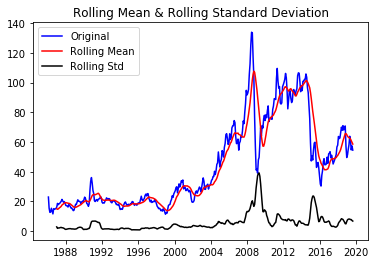

In [23]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()

plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [24]:
result = adfuller(df)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.7981792038678157
p-value: 0.3813660423289901
Critical Values:
	1%: -3.4469295619737665
	5%: -2.8688478565083417
	10%: -2.570662885558566


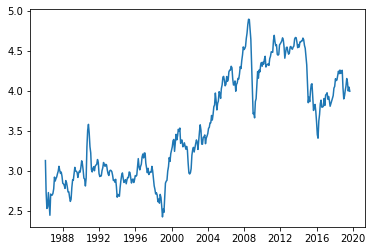

In [25]:
df_log = np.log(df)
plt.plot(df_log)

In [28]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

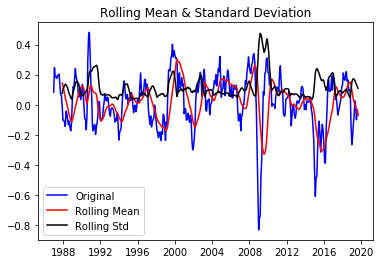

ADF Statistic: -6.935269200879083
p-value: 1.05860558301305e-09
Critical Values:
	1%: -3.4472291365835566
	5%: -2.8689795375849223
	10%: -2.5707330834976987


In [29]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

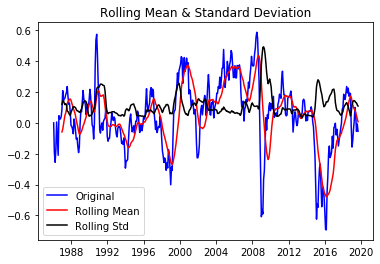

ADF Statistic: -5.078427147431217
p-value: 1.5488969664098437e-05
Critical Values:
	1%: -3.446722009322339
	5%: -2.868756617175256
	10%: -2.570614247667137


In [30]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

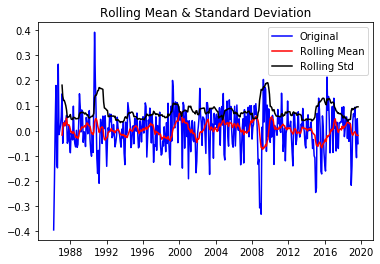

ADF Statistic: -10.121122415602159
p-value: 9.43915457507844e-18
Critical Values:
	1%: -3.446845912589748
	5%: -2.8688110853002007
	10%: -2.5706432834592747


In [31]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [56]:
#TODO
orders = itertools.product((range(1,10)),(range(1,10)),range(1,10))


/home/yuntong/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/home/yuntong/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


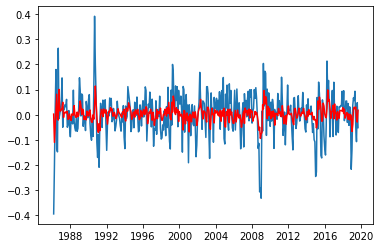

In [32]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

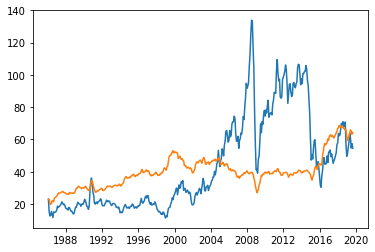

In [42]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

(-1.7981792038678157,
 0.3813660423289901,
 6,
 397,
 {'1%': -3.4469295619737665,
  '5%': -2.8688478565083417,
  '10%': -2.570662885558566},
 2170.2716047312365)

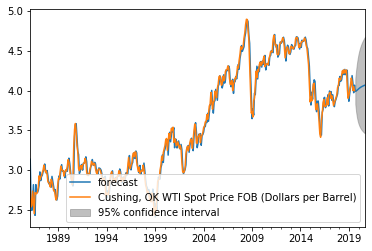

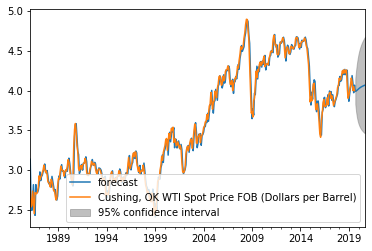

In [41]:
results.plot_predict(1,416)